# Graphs
> Comparing embeddings for Polblogs

Here we will compare 3 embedding methods:
1. Poincare embeddings:
    * This is an implementation of Nickel and Kiela's method from [Poincaré Embeddings for Learning Hierarchical Representations](https://arxiv.org/abs/1705.08039)
    * Can simply use `geomstats.datasets.prepare_graph_data.HyperbolicEmbedding`
2. Mixed-curvature embeddings:
    * This is taken from [Learning Mixed-Curvature Representations in Product Spaces](https://arxiv.org/abs/1806.02608)
    * Adapted code from [this Github repo](https://github.com/HazyResearch/hyperbolics)
3. Combinatorial algorithm:
    * This is taken from [Representation Tradeoffs for Hyperbolic Embeddings](https://arxiv.org/abs/1806.05337)
    * Adapted code from same repo as (2)

Not currently being explored:
* [Learning Continuous Hierarchies in the Lorentz Model of Hyperbolic Geometry](https://arxiv.org/abs/1806.03417)

In [1]:
%load_ext autoreload
%autoreload 2

In [159]:
import os
import sys

import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
import pandas as pd

from tqdm import tqdm_notebook as tqdm

# import geomstats
from geomstats.datasets.prepare_graph_data import Graph, HyperbolicEmbedding
from geomstats.geometry.hyperbolic import Hyperbolic

# deepcopy
from copy import deepcopy

from scipy.spatial.distance import pdist, squareform

# Repo: https://github.com/HazyResearch/hyperbolics
from hyperbolics.utils.distortions import map_score, distortion
from hyperbolics.pytorch.pytorch_hyperbolic import learn
from hyperbolics.utils import load_graph

## Load graphs

This assumes we are using the netset convention. In particular, it assumes that a 
directory contains the following files:
* `adjacency.tsv`: TSV with columns "start_node, end_node, weight"
* `labels.tsv`: TSV with column "label", ordered by node index
* `names.tsv` (optional): TSV with column "name", ordered by node index
* `names_labels.tsv` (optional): TSV with column "name", ordered by label index

In [112]:
def dense_adjacency_matrix(adjacency_path, directed=False):
    # Dense adjacency matrix: (nodes, nodes)
    adjacency = pd.read_table(adjacency_path, header=None)
    n_nodes = adjacency.max().max() + 1
    dense_adj = np.zeros((n_nodes, n_nodes))
    for i, j in zip(adjacency[0], adjacency[1]):
        dense_adj[i, j] = dense_adj[j, i] = 1

    # Final reindex
    keep1 = dense_adj.sum(axis=1) > 0
    keep2 = dense_adj.sum(axis=0) > 0
    keep = keep1 & keep2
    dense_adj = dense_adj[keep, :][:, keep]

    # # Save dense adjacency matrix
    new_path = adjacency_path.replace("/raw/", "/interim/").replace(
        ".tsv", "_dense.tsv"
    )
    os.makedirs(os.path.dirname(new_path), exist_ok=True)
    np.savetxt(new_path, dense_adj, fmt="%d", delimiter="\t")

    return dense_adj, keep


def load_graph(
    graph_dir,
    graph_type="directed",
    edge_type="unweighted",
    add_isolates=False,
):
    # Specify paths
    apath = f"{graph_dir}/adjacency.tsv"
    adpath = f"{graph_dir.replace('/raw/', '/interim/')}/adjacency_dense.tsv"
    lpath = f"{graph_dir}/labels.tsv"
    npath = f"{graph_dir}/names.tsv"
    nlpath = f"{graph_dir}/names_labels.tsv"

    # Adjacency matrix: (out_node, in_node)
    adjacency = pd.read_table(apath, header=None, usecols=[0, 1])

    # Labels: (label, )
    labels = pd.read_table(lpath, header=None, usecols=[0])[0]

    # Label name: (label_name, )
    if os.path.exists(nlpath):
        names_labels = pd.read_table(nlpath, header=None, usecols=[0])[0]
    else:
        names_labels = pd.Series(labels[0].unique()).reset_index()

    # Node name: (node_name, )
    if os.path.exists(npath):
        names = pd.read_table(npath, header=None, usecols=[0])[0]
    else:
        names = pd.Series(np.arange(len(labels))).reset_index()

    # Networkx object
    base_graph = nx.DiGraph if graph_type == "directed" else nx.Graph
    nx_graph = nx.from_pandas_edgelist(
        adjacency, source=0, target=1, create_using=base_graph
    )
    if add_isolates:
        nx_graph.add_nodes_from(names.index)

    # Geomstats Graph object
    dense_adj, keep = dense_adjacency_matrix(adjacency_path=apath)
    gs_graph = Graph(graph_matrix_path=adpath, labels_path=lpath)

    # Pairwise distances
    dists = nx.floyd_warshall_numpy(nx_graph)

    return {
        "adjacency": adjacency,
        "labels": labels,
        "names_labels": names_labels,
        "names": names,
        "nx_graph": nx_graph,
        "gs_graph": gs_graph,
        "dists": dists,
        "gs_kept": keep,
    }


polblogs = load_graph("data/raw/polblogs", graph_type="undirected")


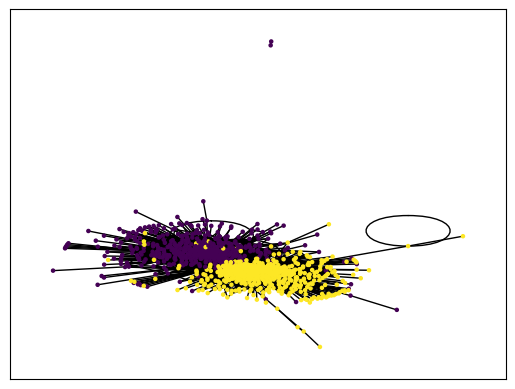

In [38]:
# Some basic plotting

nx.draw_networkx(
    polblogs["nx_graph"],
    with_labels=False,
    node_size=5,
    node_color=polblogs["labels"].reindex(polblogs["nx_graph"].nodes),
)

## Distortion and Mean average precision

**Mean average precision:** Let some node $a \in V$ have neighborhood $\mathcal{N}_a = \{b_1, b_2, \ldots, b_{deg(a)} \}$
where $a$ denotes the degree of $a$. Then we let $R_{a, b_i}$ mean the smallest set of nearest points required to retrieve the $i$-th neighbor of $a$ in our embedding space $f$. MAP is:
$$
\begin{align*}
MAP(f) &= \frac{1}{|V|} \sum_{a \in V} \frac{1}{|\mathcal{N}_a|} \sum_{i=1}^{|\mathcal{N}_a|} Precision(R_{a,b_i})\\
&= \frac{1}{|V|} \sum_{a \in V} \frac{1}{deg(a)} \sum_{i=1}^{|\mathcal{N}_a|} \frac{|\mathcal{N}_a \cap R_{a, b_i}|}{|R_{a,b_i}|}
\end{align*}
$$
Best case: $MAP(f) = 1$; not concerned with the underlying distances, only neighborhood membership.

**Distortion:** For an $n$ point embedding, the distortion is
$$
D(f) = \frac{1}{n \choose 2}\left( \frac{|d_V(f(u), f(v)) - d_U(u,v)|}{d_U(u,v)} \right)
$$

**Worst-case distortion**
$$
\begin{align}
D &= \left\{ \frac{d_V(f(u), f(v))}{d_U(u,v)} : u, v \in U, u \neq v \right\}\\
D_{wc}(f) &= \frac{\max(D)}{\min(D)}
\end{align}
$$

In [144]:
embeddings = {}
distortions = {}
precisions = {}

## Poincare embeddings (geomstats implementation)

First, we will ensure we can learn an embedding for polblogs using geomstats

INFO: Number of edges: 1224
INFO: Mean vertices by edges: 27.31454248366013


Number of nodes: 1224


INFO: iteration 0 loss_value 1.933783
INFO: iteration 1 loss_value 1.909010
INFO: iteration 2 loss_value 1.894315
INFO: iteration 3 loss_value 1.874883
INFO: iteration 4 loss_value 1.857627
INFO: iteration 5 loss_value 1.827883
INFO: iteration 6 loss_value 1.787507
INFO: iteration 7 loss_value 1.741673
INFO: iteration 8 loss_value 1.700396
INFO: iteration 9 loss_value 1.667609


Embedding shape: (1224, 2)


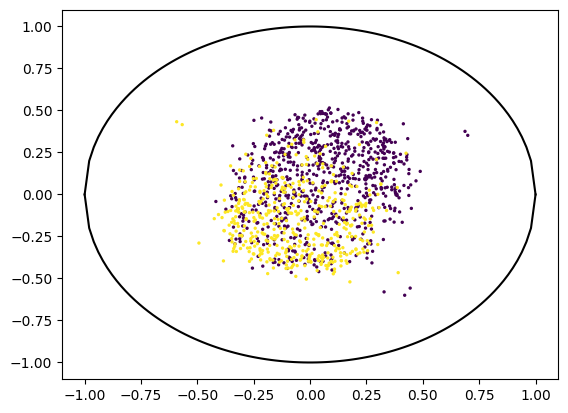

In [141]:
# Embed - geomstats
print(f"Number of nodes: {polblogs['gs_graph'].n_nodes}")
hyp_emb = HyperbolicEmbedding(
    dim=2, n_negative=10, n_context=10, lr=0.01, max_epochs=10
)
polblogs_gs_embed = hyp_emb.embed(polblogs["gs_graph"])
print(f"Embedding shape: {polblogs_gs_embed.shape}")

# Plot embeddings
plt.scatter(
    polblogs_gs_embed[:, 0],
    polblogs_gs_embed[:, 1],
    c=polblogs["labels"].reindex(polblogs["gs_graph"].edges.keys()),
    s=2,
)

# Plot poincare disk
_x = np.linspace(-1, 1, 100)
_y = np.sqrt(1 - _x**2)
plt.plot(_x, _y, c="black")
plt.plot(_x, -_y, c="black")
plt.show()

In [142]:
# Assess distortion

# Clip to max distance in embeddings
manifold = Hyperbolic(2, default_coords_type="ball")
pairwise_dists = squareform(
    pdist(polblogs_gs_embed, metric=manifold.metric.dist)
)
graph_dists = np.clip(
    polblogs["dists"], a_min=None, a_max=np.max(pairwise_dists)
)

# Assess distortion:
polblogs_gs_distortion = distortion(
    graph_dists, pairwise_dists, n=len(graph_dists), jobs=-1
)
mc, me, avg, bad = polblogs_gs_distortion
polblogs_gs_map_score = map_score(
    graph_dists, pairwise_dists, n=len(graph_dists), jobs=-1
)

print(f"Distortion: {avg}")
print(f"MAP score: {polblogs_gs_map_score}")

Distortion: 0.6529058560539441
MAP score: 0.03029756722228065


In [145]:
# Commit to dict

embeddings["polblogs_gs"] = polblogs_gs_embed
distortions["polblogs_gs"] = polblogs_gs_distortion
precisions["polblogs_gs"] = polblogs_gs_map_score

## Mixed-curvature embeddings (Hazy implementation)

For reference, the arguments for `learn`:

```python
def learn(dataset, dim=2, hyp=1, edim=1, euc=0, sdim=1, sph=0, scale=1., riemann=False, learning_rate=1e-1, decay_length=1000, decay_step=1.0, momentum=0.0, tol=1e-8, epochs=100, burn_in=0,
          use_yellowfin=False, use_adagrad=False, resample_freq=1000, print_freq=1, model_save_file=None, model_load_file=None, batch_size=16,
          num_workers=None, lazy_generation=False, log_name=None, log=False, warm_start=None, learn_scale=False, checkpoint_freq=100, sample=1., subsample=None,
          logloss=False, distloss=False, squareloss=False, symloss=False, exponential_rescale=None, extra_steps=1, use_svrg=False, T=10, use_hmds=False, visualize=False):
```

In [157]:
# Use hazy here:

prepared_dataset = 
learn()